In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from collections import Counter
from os import listdir
import base64, json, csv
import matplotlib.pyplot as plt

In [2]:
def load_data(file_name, reset=False):
    ret = pd.read_csv(file_name, sep='\t')
    return ret

In [3]:
path = '/tmp/r08922010/kdd2020/'
valid = load_data(path+'valid.tsv')
testA = load_data(path+'testA.tsv')
testB = load_data(path+'testB.tsv')

In [4]:
def sig(x):
    return 1/(1+np.e**(-x))

def load_one_file(filename, na_val, pad_len, method):
    preds = pd.read_csv(filename).fillna(na_val)
    qid2score = {}
    
    for row in preds.values:
        pid, score = row[1:pad_len+1], row[pad_len+1:]
        l = len([x for x in pid if x != na_val])
        if method == 'vote': qid2score[row[0]] = {pid[i]: weight[i] for i in range(l)}
        else: qid2score[row[0]] = {pid[i]: score[i] for i in range(l)}
        
    return qid2score

def ensemble(filenames, na_val, pad_len, thd, method='vote'):
    counts = Counter(valid['product_id'].values.tolist()+testA['product_id'].values.tolist()+testB['product_id'].values.tolist())
    print('loading files...')
    # first file
    qid2score = load_one_file(path+filenames[0], na_val, pad_len, method)
    # other files
    for filename in tqdm(filenames[1:]):
        q2s = load_one_file(path+filename, na_val, pad_len, method)
        # update score
        for qid in list(qid2score.keys()):
            for pid in list(qid2score[qid].keys()):
                qid2score[qid][pid] += q2s[qid][pid]
    # ensemble
    print('ensembling...')
    preds = {}
    for qid in tqdm(list(qid2score.keys())):
        pred = [(pid, qid2score[qid][pid]) for pid in list(qid2score[qid].keys())]
        tmp_thd = thd
        pred2 = [x for x in pred if counts[x[0]] <= tmp_thd]
        while len(pred2) < 5:
            tmp_thd += 1
            pred2 = [x for x in pred if counts[x[0]] <= tmp_thd]
        pred2.sort(key=lambda x: x[1], reverse=True)
        preds[int(qid)] = [int(pid) for pid, _ in pred2[:5]]
    return preds

def nDCG_score(preds, answers):
    iDCG = sum([sum([np.log(2)/np.log(i+2) for i in range(min(len(answer), 5))]) \
                for answer in list(answers.values())])
    DCG = sum([sum([np.log(2)/np.log(i+2) if preds[qid][i] in answers[str(qid)] else 0 \
                    for i in range(len(preds[qid]))]) for qid in list(preds.keys())])
    return DCG/iDCG

In [5]:
path = 'predictions/'
mcans = {5119: 38, 519: 39, 123: 36, 1234: 36, 12345: 31, 1213: 34, 207: 34,
         1333: 37, 2020: 36, 1115: 36, 666: 32, 2574: 39, 89983: 38, 46555: 38, 86031: 39,
         7414: 35, 71438: 38, 777: 35, 87: 35, 8787: 32, 878787: 30, 800061: 31, 856710: 31,
         42: 38, 426: 36, 64: 38, 8864: 36, 26: 39, 7382: 39, 1010: 39, 1001: 36,
         2330: 37, 612: 39, 24: 38, 25: 32, 2077: 35, 2049: 39, 2045: 39, 1917: 36,
         78667: 36, 68654: 34, 56474: 33, 56464: 36, 54367: 37, 4547: 32, 437: 36, 485: 38,
         132: 38, 257: 37, 584: 35, 931: 37, 792: 33, 603: 39, 746: 39, 480: 35}
visuals = {413: 32, 807: 37, 9527: 38, 713: 36, 625: 38, 1324: 38,
           987: 34, 116: 39, 41: 30, 145: 39,
           7328: 32, 62: 35, 3951: 37, 9736: 38}
f_m = ['prediction_all_cls2_{}_{}.csv'.format(seed, mcans[seed]) \
       for seed in list(mcans.keys()) if mcans[seed]]
f_v = ['prediction_all_cls2_{}_{}.csv'.format(seed, visuals[seed]) \
       for seed in list(visuals.keys()) if visuals[seed]]
add_visual = True
filenames = f_m+f_v if add_visual else f_m
weight = [1/i for i in range(1, 31)]
na_val = -1e10
pad_len = 30
thd = 1
method = 'sum'

# emsemble
preds = ensemble(filenames, na_val, pad_len, thd, method)
# write to file
header = ['query-id', 'product1', 'product2', 'product3', 'product4', 'product5']
with open(path+'prediction_{}_{}_{}_cls.csv'.format(method, len(filenames), thd), 'w', newline='') as f:
    w = csv.writer(f)
    w.writerow(header)
    for qid in sorted(list(preds.keys())):
        w.writerow([qid]+preds[qid])

loading files...



ensembling...


In [6]:
means = []
stds = []
n_mcan = sum([1 for seed in list(mcans.keys()) if mcans[seed]])
n_visual = sum([1 for seed in list(visuals.keys()) if visuals[seed]])
print('mcan:visual = {}:{}'.format(n_mcan, n_visual))

for filename in filenames:
    qid2score = load_one_file(path+filename, na_val, pad_len, method)
    scores = [score for qid in list(qid2score.keys()) \
              for score in list(qid2score[qid].values()) if score != na_val]
    mean = sum(scores)/len(scores)
    std = (sum([score**2 for score in scores])/len(scores) - mean**2)**0.5
    means.append(mean)
    stds.append(std)
    print('{}: mean -> {}; std -> {}'.format(filename, round(mean, 3), round(std, 3)))

mcan:visual = 55:14
prediction_all_cls2_5119_38.csv: mean -> 0.195; std -> 0.254
prediction_all_cls2_519_39.csv: mean -> 0.198; std -> 0.258
prediction_all_cls2_123_36.csv: mean -> 0.2; std -> 0.261
prediction_all_cls2_1234_36.csv: mean -> 0.212; std -> 0.24
prediction_all_cls2_12345_31.csv: mean -> 0.197; std -> 0.257
prediction_all_cls2_1213_34.csv: mean -> 0.198; std -> 0.258
prediction_all_cls2_207_34.csv: mean -> 0.208; std -> 0.243
prediction_all_cls2_1333_37.csv: mean -> 0.199; std -> 0.255
prediction_all_cls2_2020_36.csv: mean -> 0.2; std -> 0.253
prediction_all_cls2_1115_36.csv: mean -> 0.197; std -> 0.259
prediction_all_cls2_666_32.csv: mean -> 0.199; std -> 0.254
prediction_all_cls2_2574_39.csv: mean -> 0.198; std -> 0.254
prediction_all_cls2_89983_38.csv: mean -> 0.202; std -> 0.258
prediction_all_cls2_46555_38.csv: mean -> 0.198; std -> 0.258
prediction_all_cls2_86031_39.csv: mean -> 0.196; std -> 0.257
prediction_all_cls2_7414_35.csv: mean -> 0.207; std -> 0.235
predictio

(array([ 2.,  7., 10., 16., 14.,  7.,  5.,  6.,  1.,  1.]),
 array([0.19226365, 0.19425656, 0.19624948, 0.19824239, 0.2002353 ,
        0.20222821, 0.20422113, 0.20621404, 0.20820695, 0.21019986,
        0.21219278]),
 <a list of 10 Patch objects>)

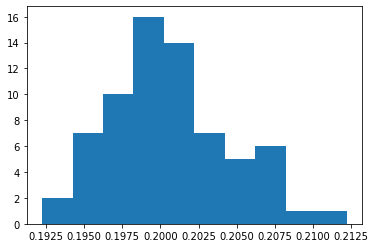

In [7]:
plt.hist(means)

(array([ 1.,  1.,  3.,  2.,  2.,  9., 19., 20.,  9.,  3.]),
 array([0.23514857, 0.23829719, 0.24144581, 0.24459443, 0.24774306,
        0.25089168, 0.2540403 , 0.25718893, 0.26033755, 0.26348617,
        0.26663479]),
 <a list of 10 Patch objects>)

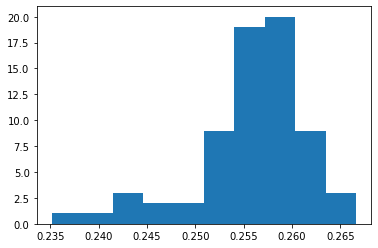

In [8]:
plt.hist(stds)